In [88]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchinfo import summary

from tqdm import tqdm
from tqdm.notebook import tqdm

import numpy as np
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

## Датасет

In [48]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

transform = torchvision.transforms.Compose([
    lambda img: torchvision.transforms.functional.rotate(img, -90),
    lambda img: torchvision.transforms.functional.hflip(img),
    torchvision.transforms.ToTensor()
])

train_data = datasets.EMNIST(
    root='data',
    split='letters',
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.EMNIST(
    root='data',
    split='letters',
    train=False,
    download=True,
    transform=transform
)

In [49]:
print("Train size: ", len(train_data))
print("Test size: ", len(test_data))
n_classes = len(train_data.classes)
print("Classes: ", train_data.classes)
print("[C, W, H]: ", {train_data[0][0].size()})



Train size:  124800
Test size:  20800
Classes:  ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[C, W, H]:  {torch.Size([1, 28, 28])}


In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

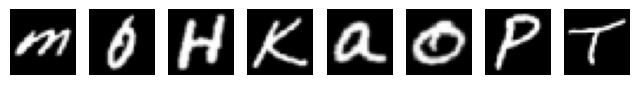

In [87]:
figure = plt.figure(figsize=(8, 8))
N = 8
for i in range(1, N+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(1, N, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.axis("off")
plt.show()

## Обучение модели

In [53]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()

    output = model(x_batch.to(device))

    loss = loss_function(output, y_batch.to(device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [54]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(device), batch_of_y.to(device), optimizer, loss_function)

        if callback is not None:
            callback(model, batch_loss)

        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)

    return epoch_loss/total

In [55]:
def trainer(count_of_epoch,
            batch_size,
            dataset,
            model,
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)

    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True),
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))

        epoch_loss = train_epoch(train_generator=batch_generator,
                                 model=model,
                                 loss_function=loss_function,
                                 optimizer=optima,
                                 callback=callback)

        iterations.set_postfix({'train epoch loss': epoch_loss})

In [56]:
def trainer_quality(model,
                    dataset,
                    loss_function,
                    batch_size):

    batch_generator = torch.utils.data.DataLoader(dataset=dataset,
                                                  batch_size=batch_size)

    pred = []
    real = []
    test_loss = 0

    for it, (x_batch, y_batch) in enumerate(batch_generator):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(x_batch)

        test_loss += loss_function(output, y_batch).cpu().item() * len(x_batch)

        pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
        real.extend(y_batch.cpu().numpy().tolist())

    test_loss /= len(dataset)

    return test_loss, pred, real

## Модель

In [57]:
class CNN(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device
            
    def __init__(self, n_layers = 1, kernel_size = 1, pooling = False,
                 batch_norm = False, dropout = 0.0):
        super().__init__()
        
        # Черно-белая картина - 1 канал 
        self.n_channels = 1
        self.layers = torch.nn.Sequential()

        for layer in range(n_layers):
            self.layers.add_module(f'Conv2d for {layer}',
                torch.nn.Conv2d(self.n_channels, self.n_channels * 4, kernel_size = kernel_size))
            
            self.n_channels *= 4

            if batch_norm:
                self.layers.add_module(f'BatchNorm2d for {layer}', torch.nn.BatchNorm2d(self.n_channels))

            self.layers.add_module(f'ReLU for {layer}', torch.nn.ReLU())

            if pooling:
                self.layers.add_module(f'MaxPool2d for {layer}', torch.nn.MaxPool2d(kernel_size=2))

        self.layers.add_module('flatten', torch.nn.Flatten())
        self.layers.add_module('dropout', torch.nn.Dropout(dropout))
        self.layers.add_module('linear', torch.nn.LazyLinear(n_classes))

    def forward(self, input):
        return self.layers(input)

## Tensorboard callback

In [58]:
class tensorboard_callback:
    def __init__(self, writer, dataset, loss_function, delimeter, batch_size):
        self.step = 0
        self.writer = writer
        self.dataset = dataset
        self.loss_function = loss_function
        self.delimeter = delimeter
        self.batch_size = batch_size

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)

        if self.step % self.delimeter == 0:
            self.writer.add_graph(model, self.dataset[0][0].view(1, 1, 28, 28).to(model.device))
            test_loss, pred, real = trainer_quality(model=model, dataset=self.dataset,
                                                    loss_function=self.loss_function, batch_size=self.batch_size)
            self.writer.add_scalar('LOSS/test', test_loss, self.step)

    def __call__(self, model, loss):
        return self.forward(model, loss)

## Запуск для конкретных гридов

In [59]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
batch_size = 128

In [85]:
grid = ParameterGrid({
    'n_layers': [2, 3],
    'kernel_size': [2, 3],
    'pooling': [True, False],
    'batch_norm': [True, False],
    'dropout': [0.0, 0.5],
})

for params in tqdm(grid):
    print(str(params))

    model = CNN(**params)
    mod = model.to(device)
    
    writer = SummaryWriter(f'runs/{str(params)}')
    callback = tensorboard_callback(writer, test_data, loss_function, batch_size=batch_size, delimeter=200)

    trainer(count_of_epoch = 2, batch_size = batch_size, dataset = train_data,
            model = model, loss_function = loss_function, optimizer = optimizer,
            lr = 0.001, callback = callback)


  0%|          | 0/32 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 2, 'n_layers': 2, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 2, 'n_layers': 2, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 2, 'n_layers': 3, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 2, 'n_layers': 3, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 2, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 2, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 3, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 3, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 2, 'n_layers': 2, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 2, 'n_layers': 2, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 2, 'n_layers': 3, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 2, 'n_layers': 3, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 3, 'n_layers': 2, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 3, 'n_layers': 2, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 3, 'n_layers': 3, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': True, 'dropout': 0.5, 'kernel_size': 3, 'n_layers': 3, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 2, 'n_layers': 2, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 2, 'n_layers': 2, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 2, 'n_layers': 3, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 2, 'n_layers': 3, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 2, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 2, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 3, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.0, 'kernel_size': 3, 'n_layers': 3, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 2, 'n_layers': 2, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 2, 'n_layers': 2, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 2, 'n_layers': 3, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 2, 'n_layers': 3, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 3, 'n_layers': 2, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 3, 'n_layers': 2, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 3, 'n_layers': 3, 'pooling': True}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

{'batch_norm': False, 'dropout': 0.5, 'kernel_size': 3, 'n_layers': 3, 'pooling': False}


epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

  0%|          | 0/975 [00:00<?, ?it/s]

## Выводы

Реализована CNN, обученная на EMNIST, проведен grid-search по гиперпараметрам и выполнена оценка loss.

Результаты:
- Увеличение кол-ва слоев и kernel size улучшают качество модели
- BatchNorm, Pooling и Dropout ухудшают качество модели

Наилучший результат показал CNN с 3 слоями и kernel size равный 3, при этом без BatchNorm, Pooling и Dropout.

Стоит отметить, что включение BatchNorm и Pooling увеличивает loss на целый порядок.
